# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'autoencoder'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_lstm_autoencoder_unscaled_15.csv', shape=(28478, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28511_12_5_fc_vae_unscaled.csv', shape=(28511, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume           temp   rain_1h   snow_1h     clouds_all
count   341736.000000  341736.000000  341736.0  341736.0  341736.000000
mean      3246.959198     282.898453       0.0       0.0      41.946411
std       1898.209145      12.331297       0.0       0.0      39.537222
min          0.000000     245.715363       0.0       0.0       0.000000
25%       1342.486206     273.555267       0.0       0.0       0.000000
50%       3681.667603     284.773941       0.0       0.0      34.915749
75%       4856.334717     293.137657       0.0       0.0      88.441345
max       8375.253906     309.613892       0.0       0.0     123.771759


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511.000000  28511.000000
mean       3313.74238    282.688768      0.061611      0.000250     42.122795
std        1971.53206     12.367361      0.678185      0.008298     39.316195
min         

In [6]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,341736.000000,341736.000000,341736.0,341736.0,341736.000000
mean,3246.959198,282.898453,0.0,0.0,41.946411
std,1898.209145,12.331297,0.0,0.0,39.537222
min,0.000000,245.715363,0.0,0.0,0.000000
25%,1342.486206,273.555267,0.0,0.0,0.000000
50%,3681.667603,284.773941,0.0,0.0,34.915749
75%,4856.334717,293.137657,0.0,0.0,88.441345
max,8375.253906,309.613892,0.0,0.0,123.771759


In [7]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [8]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [9]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.302078623175621
Training Loss: 0.23647089973092078
Training Loss: 0.18830791998654603
Validation Loss: 0.15047654216544012
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1231865806505084
Training Loss: 0.08578080425038934
Training Loss: 0.06995305432006717
Validation Loss: 0.05991326594788037
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.062169998548924923
Training Loss: 0.06025682164356112
Training Loss: 0.06081202896311879
Validation Loss: 0.05351726124795635
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05641878524795175
Training Loss: 0.05401589389890432
Training Loss: 0.05403769394382835
Validation Loss: 0.04648810122789961
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04891425156034529
Training Loss: 0.04568071413785219
Training Loss: 

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:24<30:43, 204.85s/it]

Epoch: 1
Training Loss: 0.5475918418169021
Training Loss: 0.40951029434800146
Training Loss: 0.2854310147464275
Validation Loss: 0.1799112426096134
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.14704320274293423
Training Loss: 0.09728973284363747
Training Loss: 0.07465944761410355
Validation Loss: 0.05838906637319688
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06205565163865685
Training Loss: 0.05862491704523563
Training Loss: 0.05824439890682697
Validation Loss: 0.05039996559616555
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05437875358387828
Training Loss: 0.05148218717426062
Training Loss: 0.050996964257210495
Validation Loss: 0.04325983480791028
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.046595719270408155
Training Loss: 0.043343256907537576
Training Loss

 20%|██        | 2/10 [06:52<27:31, 206.39s/it]

Training Loss: 0.0052367090672487395
Validation Loss: 0.002278004980939074
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.12207800880074501
Training Loss: 0.08720184156671167
Training Loss: 0.0700758047774434
Validation Loss: 0.059870056473137284
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06121494561433792
Training Loss: 0.05783307876437902
Training Loss: 0.05686852160841226
Validation Loss: 0.05326995877235123
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05278079979121685
Training Loss: 0.0486618254519999
Training Loss: 0.046996247740462425
Validation Loss: 0.04236475227589018
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0417180298268795
Training Loss: 0.036914833374321464
Training Loss: 0.03526454675011337
Validation Loss: 0.030511603366290586
Validation Accur

 30%|███       | 3/10 [10:20<24:09, 207.06s/it]

Training Loss: 0.00546454191673547
Validation Loss: 0.002523694857117835
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.25315521746873854
Training Loss: 0.19980930745601655
Training Loss: 0.15584398590028287
Validation Loss: 0.10798916739694188
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.097669364400208
Training Loss: 0.06872061457484961
Training Loss: 0.05681084515526891
Validation Loss: 0.050636770099066614
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.051209032237529754
Training Loss: 0.04815790658816695
Training Loss: 0.047457664422690865
Validation Loss: 0.04376908042206523
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.043459065901115534
Training Loss: 0.03997403396293521
Training Loss: 0.03891361680813134
Validation Loss: 0.03450964353560062
Validation Accura

 40%|████      | 4/10 [13:46<20:40, 206.80s/it]

Training Loss: 0.005095520982285962
Validation Loss: 0.002199879010977077
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07475654780864716
Training Loss: 0.0706701054237783
Training Loss: 0.06928331507369875
Validation Loss: 0.060949450463391425
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06306573616340756
Training Loss: 0.05917439855635166
Training Loss: 0.05710332395508885
Validation Loss: 0.04872404830007071
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0498647187743336
Training Loss: 0.044757490204647185
Training Loss: 0.04193833509460092
Validation Loss: 0.03411483050983274
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03485722072422504
Training Loss: 0.030075630648061635
Training Loss: 0.02842739107552916
Validation Loss: 0.022947448515071626
Validation Accur

 50%|█████     | 5/10 [17:12<17:12, 206.52s/it]

Training Loss: 0.006640147640719078
Validation Loss: 0.0035206628858708263
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.10943059962242842
Training Loss: 0.08739918671548366
Training Loss: 0.07817213075235487
Validation Loss: 0.07020692950051823
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07063852401450277
Training Loss: 0.06627579130232335
Training Loss: 0.06340356808155775
Validation Loss: 0.05458980062034693
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05496518965810537
Training Loss: 0.049776218803599476
Training Loss: 0.047187068266794086
Validation Loss: 0.039156394665328303
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03938595940358937
Training Loss: 0.03504627252928913
Training Loss: 0.033453597044572236
Validation Loss: 0.027210357201317054
Validation A

 60%|██████    | 6/10 [20:38<13:45, 206.45s/it]

Training Loss: 0.006698238974204287
Validation Loss: 0.0035949517342293365
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07226881040260195
Training Loss: 0.0657392812334001
Training Loss: 0.06437784632667899
Validation Loss: 0.058476611511426024
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05888112245127559
Training Loss: 0.054805791713297365
Training Loss: 0.05231790329329669
Validation Loss: 0.044766661595929874
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04451798000372946
Training Loss: 0.039601640123873946
Training Loss: 0.037855622479692104
Validation Loss: 0.03162762374104409
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03190886083990335
Training Loss: 0.028180297459475697
Training Loss: 0.027825158056803048
Validation Loss: 0.023199045298139702
Validation

 70%|███████   | 7/10 [24:04<10:18, 206.26s/it]

Training Loss: 0.006771830504294485
Validation Loss: 0.0036304139642023975
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.24094672217965127
Training Loss: 0.1740432384237647
Training Loss: 0.1253568537160754
Validation Loss: 0.08258855522850926
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07898483904078603
Training Loss: 0.06348733756691217
Training Loss: 0.05821655648760497
Validation Loss: 0.051200929778010655
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.052797124460339545
Training Loss: 0.04888508319854736
Training Loss: 0.04729446324519813
Validation Loss: 0.04122191498035126
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04177706193178892
Training Loss: 0.037205400289967654
Training Loss: 0.03526051625143736
Validation Loss: 0.029355542838908313
Validation Accu

 80%|████████  | 8/10 [27:30<06:52, 206.06s/it]

Training Loss: 0.005770116103813052
Validation Loss: 0.002694369450713811
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07206085599958896
Training Loss: 0.06872662752866746
Training Loss: 0.06692183166742324
Validation Loss: 0.06088658694303437
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05926250651478768
Training Loss: 0.055302737411111594
Training Loss: 0.0533639313839376
Validation Loss: 0.04585931671971685
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04521511369384825
Training Loss: 0.040989618357270954
Training Loss: 0.03964517394080758
Validation Loss: 0.032696331652362694
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03290405532345176
Training Loss: 0.029339859457686544
Training Loss: 0.028969653835520148
Validation Loss: 0.02359868601759833
Validation Acc

 90%|█████████ | 9/10 [30:56<03:26, 206.06s/it]

Training Loss: 0.006161149934632704
Validation Loss: 0.003061197501910704
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.12344494175165892
Training Loss: 0.0925901368074119
Training Loss: 0.07474483985453845
Validation Loss: 0.06100982209939635
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06418218851089477
Training Loss: 0.060410283654928204
Training Loss: 0.05866233566775918
Validation Loss: 0.05031930889641301
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05312009887769818
Training Loss: 0.04841942636296153
Training Loss: 0.046092929374426606
Validation Loss: 0.03763935779838749
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03956792094744742
Training Loss: 0.034417172316461804
Training Loss: 0.03249875750392675
Validation Loss: 0.026229149452672247
Validation Accu

100%|██████████| 10/10 [34:22<00:00, 206.05s/it]

Training Loss: 0.006777936298167333
Validation Loss: 0.0034683951532489127
Validation Accuracy: 0.0
**************************************************


100%|██████████| 10/10 [34:22<00:00, 206.25s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.40201940402388575
Training Loss: 0.30923484995961187
Training Loss: 0.21224737461656332
Validation Loss: 0.13114954573049975
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.10605421781539917
Training Loss: 0.07649544866755605
Training Loss: 0.06533143132925033
Validation Loss: 0.0632235925602779
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0602048122882843
Training Loss: 0.05802156349644065
Training Loss: 0.05545197039842606
Validation Loss: 0.05490725192377407
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05234483839944005
Training Loss: 0.049797275261953475
Training Loss: 0.04702913337387145
Validation Loss: 0.046075232033984045
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.043918764451518655
Training Loss: 0.041024295473471285
Training Lo

 10%|█         | 1/10 [03:27<31:04, 207.16s/it]

Validation Loss: 0.0036363801513432286
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.06871905330568552
Training Loss: 0.06580453274771571
Training Loss: 0.06305145982652903
Validation Loss: 0.060545072336210294
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05743449229747057
Training Loss: 0.05389316702261567
Training Loss: 0.049868303555995225
Validation Loss: 0.04639430264576098
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04375447290949523
Training Loss: 0.03989239256829023
Training Loss: 0.03629991681315005
Validation Loss: 0.033568200864567514
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.031985730906017126
Training Loss: 0.028855687282048167
Training Loss: 0.026517566912807523
Validation Loss: 0.024647984815907947
Validation Accuracy: 0.0
*********************

 20%|██        | 2/10 [06:54<27:37, 207.14s/it]

Validation Loss: 0.002677241249370985
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07318329527974128
Training Loss: 0.06880074519664049
Training Loss: 0.06572486847639084
Validation Loss: 0.06340371183213893
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.060686688013374804
Training Loss: 0.05803591752424836
Training Loss: 0.05452014178037643
Validation Loss: 0.051244518039434146
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04890156020410359
Training Loss: 0.045577889429405334
Training Loss: 0.04176560243591666
Validation Loss: 0.03815405716428931
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03637672854587436
Training Loss: 0.03289727162569761
Training Loss: 0.029603247148916125
Validation Loss: 0.026338933391517466
Validation Accuracy: 0.0
************************

 30%|███       | 3/10 [10:21<24:09, 207.10s/it]

Validation Loss: 0.003478570728761594
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4888237053155899
Training Loss: 0.3806202162057161
Training Loss: 0.2793828117847443
Validation Loss: 0.19153792900818117
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.15998392939567566
Training Loss: 0.11030255166813731
Training Loss: 0.08246716655790806
Validation Loss: 0.07082002049081781
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06667312674224377
Training Loss: 0.06326326727867126
Training Loss: 0.06111062694340944
Validation Loss: 0.061323098712757734
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05894584221765399
Training Loss: 0.05765442087315023
Training Loss: 0.05583799509331584
Validation Loss: 0.05582717236843002
Validation Accuracy: 0.0
*******************************

 40%|████      | 4/10 [13:48<20:42, 207.00s/it]

Validation Loss: 0.0037220231835531554
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.23674567319452763
Training Loss: 0.1856905360892415
Training Loss: 0.15074796192348003
Validation Loss: 0.13299436980251517
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11800534270703793
Training Loss: 0.10438780708238482
Training Loss: 0.09449321949854493
Validation Loss: 0.09043453518677963
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0846947880834341
Training Loss: 0.08191661054268479
Training Loss: 0.07895191412419081
Validation Loss: 0.07709170515868771
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07362411951646208
Training Loss: 0.07182853473350406
Training Loss: 0.06908689657226205
Validation Loss: 0.06673989880285906
Validation Accuracy: 0.0
******************************

 50%|█████     | 5/10 [17:15<17:15, 207.01s/it]

Validation Loss: 0.003842492427629827
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.14264847606420517
Training Loss: 0.11729558076709509
Training Loss: 0.09947757562622428
Validation Loss: 0.09132410945852151
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0820999233238399
Training Loss: 0.07668496621772647
Training Loss: 0.0731376208551228
Validation Loss: 0.07132084406075183
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06795654181391
Training Loss: 0.06643197748810054
Training Loss: 0.06433795707300305
Validation Loss: 0.062275393834609664
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05943459391593933
Training Loss: 0.05713544043712318
Training Loss: 0.05419715594500303
Validation Loss: 0.050936849578545336
Validation Accuracy: 0.0
********************************

 60%|██████    | 6/10 [20:42<13:48, 207.08s/it]

Validation Loss: 0.0035178227516236516
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.09756047712638974
Training Loss: 0.07457333415746689
Training Loss: 0.06278905680403113
Validation Loss: 0.05901397574232536
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05602305555716157
Training Loss: 0.05364769062027335
Training Loss: 0.05067939901724458
Validation Loss: 0.04800209323509356
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04537326557561755
Training Loss: 0.04186424122191965
Training Loss: 0.03813965394161642
Validation Loss: 0.0345613711482186
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.032647872986271975
Training Loss: 0.02901188449934125
Training Loss: 0.026099546747282147
Validation Loss: 0.02317646605203326
Validation Accuracy: 0.0
***************************

 70%|███████   | 7/10 [24:09<10:21, 207.09s/it]

Validation Loss: 0.0029472891703049204
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.15783626820892097
Training Loss: 0.1084752350859344
Training Loss: 0.07931769173592329
Validation Loss: 0.06814246392400747
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06274038070812821
Training Loss: 0.06051538549363613
Training Loss: 0.05882867118343711
Validation Loss: 0.05681684174773733
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05494079915806651
Training Loss: 0.05325291708111763
Training Loss: 0.05069328706711531
Validation Loss: 0.04717313252347574
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.045218748934566975
Training Loss: 0.04189110031351447
Training Loss: 0.037835525274276735
Validation Loss: 0.031927286819921116
Validation Accuracy: 0.0
**************************

 80%|████████  | 8/10 [27:36<06:54, 207.09s/it]

Validation Loss: 0.0028564400887221434
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5071079547703267
Training Loss: 0.38480207562446594
Training Loss: 0.2826035285741091
Validation Loss: 0.20543551704521928
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1715266053006053
Training Loss: 0.12225940372794866
Training Loss: 0.08810422580689192
Validation Loss: 0.06759061231120919
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058913336507976054
Training Loss: 0.04958485899493098
Training Loss: 0.04493284547701478
Validation Loss: 0.042933447537629794
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04083923169411719
Training Loss: 0.03819453218951821
Training Loss: 0.03534175089560449
Validation Loss: 0.032912796624841985
Validation Accuracy: 0.0
****************************

 90%|█████████ | 9/10 [31:03<03:26, 206.90s/it]

Validation Loss: 0.00391251725939971
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6791194249689579
Training Loss: 0.5604348748922348
Training Loss: 0.4496465115249157
Validation Loss: 0.35545794473270353
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.29307486094534396
Training Loss: 0.1988304240256548
Training Loss: 0.1297872241586447
Validation Loss: 0.09325810316740797
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07747732043266296
Training Loss: 0.06479454144835473
Training Loss: 0.059366241376847026
Validation Loss: 0.0565869797104865
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05422497345134616
Training Loss: 0.05197796347551048
Training Loss: 0.04898481633514166
Validation Loss: 0.04540657891441932
Validation Accuracy: 0.0
***********************************

100%|██████████| 10/10 [34:29<00:00, 206.98s/it]


Validation Loss: 0.0034260127315391903
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.05905972303822637
Training Loss: 0.0543162904959172
Training Loss: 0.05515714993700385
Validation Loss: 0.0544659620088138
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05431057216599584
Training Loss: 0.05014838262461126
Training Loss: 0.05059655996970833
Validation Loss: 0.04950565724434813
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04911679192446172
Training Loss: 0.04484334518201649
Training Loss: 0.04463148915208876
Validation Loss: 0.04283988263374299
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04211130707524717
Training Loss: 0.03760422454215586
Training Loss: 0.03669127750210464
Validation Loss: 0.03425227359376764
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.033101775334216654
Training Loss: 0.028583271163515746
Training Loss

 10%|█         | 1/10 [03:27<31:05, 207.33s/it]

Validation Loss: 0.0002784562752771144
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2377791552245617
Training Loss: 0.1765631826967001
Training Loss: 0.13910855326801538
Validation Loss: 0.10756143005669452
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08916479707695543
Training Loss: 0.06385855881031603
Training Loss: 0.05291487731505185
Validation Loss: 0.04729215241445417
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04570674727205187
Training Loss: 0.04099943969864398
Training Loss: 0.0416360124386847
Validation Loss: 0.040755118818932706
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.040851221745833756
Training Loss: 0.037153630200773474
Training Loss: 0.037543921531178054
Validation Loss: 0.03634397676109933
Validation Accuracy: 0.0
***************************

 20%|██        | 2/10 [06:55<27:42, 207.77s/it]

Validation Loss: 0.0002710484549108228
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.36034599132835865
Training Loss: 0.24909571420401336
Training Loss: 0.1918095066025853
Validation Loss: 0.1270247923231192
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.10724495427682995
Training Loss: 0.06878338692244142
Training Loss: 0.061165536078624426
Validation Loss: 0.05192621671751644
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04902118655852974
Training Loss: 0.044518734337761996
Training Loss: 0.04626438884995878
Validation Loss: 0.04596430268347933
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04449350356124342
Training Loss: 0.042605488179251555
Training Loss: 0.043698115088045594
Validation Loss: 0.043563612203082344
Validation Accuracy: 0.0
*************************

 30%|███       | 3/10 [10:23<24:14, 207.78s/it]

**************************************************
Epoch: 1
Training Loss: 0.06576249716803431
Training Loss: 0.05418301508761943
Training Loss: 0.05427597297821194
Validation Loss: 0.052747902952218324
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0509437835868448
Training Loss: 0.0474252404179424
Training Loss: 0.04740952991880477
Validation Loss: 0.04630530803474817
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04427702384069562
Training Loss: 0.041031256122514605
Training Loss: 0.04061008437536657
Validation Loss: 0.03927261371877086
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03695698196068406
Training Loss: 0.0338742159307003
Training Loss: 0.033212786787189544
Validation Loss: 0.03179720523400923
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.029218497257679

 40%|████      | 4/10 [13:52<20:51, 208.54s/it]

Validation Loss: 0.0003174657155458784
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.23950834352523087
Training Loss: 0.16066266983747482
Training Loss: 0.13140018589794636
Validation Loss: 0.09496219006230992
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08600501316133886
Training Loss: 0.0604232852673158
Training Loss: 0.0566932540666312
Validation Loss: 0.049934371133868616
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04767172288149595
Training Loss: 0.04311793244909495
Training Loss: 0.04381303558591753
Validation Loss: 0.04373531664062417
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04153481585439295
Training Loss: 0.03916051186155528
Training Loss: 0.03877642608247697
Validation Loss: 0.0385107469033408
Validation Accuracy: 0.0
******************************

 50%|█████     | 5/10 [17:21<17:23, 208.71s/it]

Epoch: 1
Training Loss: 0.12141200395300984
Training Loss: 0.08501381611451507
Training Loss: 0.06447243178728967
Validation Loss: 0.051251079301151
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.046673102625645696
Training Loss: 0.04049032495357096
Training Loss: 0.04032209529541433
Validation Loss: 0.039290042133646064
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03841191622428596
Training Loss: 0.03480798332951963
Training Loss: 0.0347104789223522
Validation Loss: 0.03335961243765575
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03237356315366924
Training Loss: 0.028729653558693825
Training Loss: 0.0281746773654595
Validation Loss: 0.026543432564129322
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.025394838517531753
Training Loss: 0.021937407441437243
Training Lo

 60%|██████    | 6/10 [20:51<13:55, 208.93s/it]

Validation Loss: 0.0002633333397885978
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11819077977910637
Training Loss: 0.07499823594931514
Training Loss: 0.06083588239736855
Validation Loss: 0.04764237863880195
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04427565953694284
Training Loss: 0.04001031540799886
Training Loss: 0.041480304803699256
Validation Loss: 0.04093219544947817
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03889740680344403
Training Loss: 0.03674705585464835
Training Loss: 0.03744209065102041
Validation Loss: 0.036712622636238514
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03480075229424983
Training Loss: 0.03247898606117815
Training Loss: 0.03292441736906767
Validation Loss: 0.03192132383877976
Validation Accuracy: 0.0
**************************

 70%|███████   | 7/10 [24:20<10:27, 209.05s/it]

Validation Loss: 0.00021211376629202115
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.09141914080828428
Training Loss: 0.06566711913328618
Training Loss: 0.05732212938833982
Validation Loss: 0.05244390621488349
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05021406508982182
Training Loss: 0.04653413240797818
Training Loss: 0.04664215655997395
Validation Loss: 0.045876686021769315
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0444180244486779
Training Loss: 0.04100357146002352
Training Loss: 0.04062280866317451
Validation Loss: 0.039423707223842655
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03805834199301898
Training Loss: 0.03447068314999342
Training Loss: 0.03368252007290721
Validation Loss: 0.03224476168894868
Validation Accuracy: 0.0
**************************

 80%|████████  | 8/10 [27:50<06:58, 209.25s/it]

Validation Loss: 0.00032237216076824103
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08216954976320266
Training Loss: 0.0562719884654507
Training Loss: 0.05038822283968329
Validation Loss: 0.04783493932336569
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04674696819856763
Training Loss: 0.042183371102437375
Training Loss: 0.0419742220826447
Validation Loss: 0.04057651891090562
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0395735136885196
Training Loss: 0.03523837808985263
Training Loss: 0.03460380439646542
Validation Loss: 0.033246828897155065
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03175509988795966
Training Loss: 0.027653256845660508
Training Loss: 0.026768345716409386
Validation Loss: 0.025848584882705736
Validation Accuracy: 0.0
*************************

 90%|█████████ | 9/10 [31:19<03:29, 209.19s/it]

Validation Loss: 0.0002846631710433919
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.43744898565113544
Training Loss: 0.30942567478865385
Training Loss: 0.20796009762212633
Validation Loss: 0.11264029006065612
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08474217375740409
Training Loss: 0.05489171599037945
Training Loss: 0.05208688598126173
Validation Loss: 0.05130004916298256
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05039724788628518
Training Loss: 0.04710956039838493
Training Loss: 0.04719001207500696
Validation Loss: 0.04658752951896592
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.045609220210462806
Training Loss: 0.04244123172014952
Training Loss: 0.04238333459943533
Validation Loss: 0.041600269422437365
Validation Accuracy: 0.0
**************************

100%|██████████| 10/10 [34:48<00:00, 208.88s/it]


Validation Loss: 0.0004219007085625532
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.06605902584269643
Training Loss: 0.054798267371952536
Training Loss: 0.048966829981654886
Training Loss: 0.04660055962391198
Training Loss: 0.044345361087471245
Training Loss: 0.040386728495359424
Training Loss: 0.04092342170886695
Validation Loss: 0.039654645713025266
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03959111014381051
Training Loss: 0.03786943444982171
Training Loss: 0.035078337471932175
Training Loss: 0.032003487558104095
Training Loss: 0.029118202910758555
Training Loss: 0.02544988406356424
Training Loss: 0.025466061639599503
Validation Loss: 0.024893534725552863
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.024944623471237718
Training Loss: 0.02332357011269778
Training Loss: 0.02115360719617456
Training Loss: 0.01848167591248057
Training Loss: 0.015865231633652003
Training Loss: 0.01380924579454586
Training Loss: 0.01397881206125021


 10%|█         | 1/10 [06:46<1:00:59, 406.64s/it]

Training Loss: 0.0007246871229290263
Validation Loss: 0.0014361953652770806
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5789755254983902
Training Loss: 0.4606658312678337
Training Loss: 0.3443205516040325
Training Loss: 0.2232553483173251
Training Loss: 0.11788016712293028
Training Loss: 0.054098307266831396
Training Loss: 0.047110863281413916
Validation Loss: 0.04474669727688648
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04389770399779081
Training Loss: 0.043568514678627254
Training Loss: 0.04181354228407144
Training Loss: 0.04049382069148123
Training Loss: 0.03886282755527645
Training Loss: 0.03491924089379608
Training Loss: 0.036240300540812315
Validation Loss: 0.035517871589138265
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03534822409041226
Training Loss: 0.03479004641994834
Training Loss: 0.03269896393641829

 20%|██        | 2/10 [13:35<54:21, 407.67s/it]  

Training Loss: 0.0007305826782248914
Validation Loss: 0.0013609359630345182
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6435705126821994
Training Loss: 0.5481304877996445
Training Loss: 0.4487703701853752
Training Loss: 0.34402399219572544
Training Loss: 0.22161647306755186
Training Loss: 0.12418349731713534
Training Loss: 0.06837743741925806
Validation Loss: 0.05121208233096068
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.049928108332678675
Training Loss: 0.04516719081439078
Training Loss: 0.04202083826996386
Training Loss: 0.039750502100214365
Training Loss: 0.039499759990721944
Training Loss: 0.037726065600290896
Training Loss: 0.03659979742951691
Validation Loss: 0.03631146404236443
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.036621268950402734
Training Loss: 0.035901008695364
Training Loss: 0.03320964890532196


 30%|███       | 3/10 [20:23<47:36, 408.06s/it]

Training Loss: 0.0007485616199846845
Validation Loss: 0.0012437430356366714
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.33438097320497034
Training Loss: 0.2613008393347263
Training Loss: 0.19088285271078348
Training Loss: 0.13941413907334207
Training Loss: 0.09293915807269514
Training Loss: 0.06068215602543205
Training Loss: 0.05348109953571111
Validation Loss: 0.04767778574415807
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04556274935603142
Training Loss: 0.04296330453827977
Training Loss: 0.040924685113132
Training Loss: 0.039649960109964015
Training Loss: 0.03827489677816629
Training Loss: 0.03467549787834287
Training Loss: 0.03583185188472271
Validation Loss: 0.03461630078039589
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03487248074263334
Training Loss: 0.03380304898135364
Training Loss: 0.031723333904519674
T

 40%|████      | 4/10 [27:13<40:53, 408.93s/it]

Training Loss: 0.0004431143204419641
Validation Loss: 0.000949018826755723
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.09457092912867665
Training Loss: 0.06956101965159178
Training Loss: 0.05869472922757268
Training Loss: 0.05607806028798223
Training Loss: 0.05385102066211402
Training Loss: 0.04906863782554865
Training Loss: 0.05082550181075931
Validation Loss: 0.049446231130971
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04918529111891985
Training Loss: 0.04830878039821982
Training Loss: 0.04591622937470675
Training Loss: 0.04367520649917424
Training Loss: 0.0412002788297832
Training Loss: 0.0364699989836663
Training Loss: 0.03681033724918961
Validation Loss: 0.03526721111313904
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03514837290160358
Training Loss: 0.033531127432361245
Training Loss: 0.030579280452802778
Tra

 50%|█████     | 5/10 [34:00<33:59, 407.96s/it]

Training Loss: 0.00044282451024628243
Validation Loss: 0.00098335531609759
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.057168611343950036
Training Loss: 0.05663992460817099
Training Loss: 0.05472356589511037
Training Loss: 0.05289089317433536
Training Loss: 0.05064770969562232
Training Loss: 0.04580290531739593
Training Loss: 0.04612698655575514
Validation Loss: 0.04433339181938645
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.044084835583344105
Training Loss: 0.04201403493061662
Training Loss: 0.0384079877845943
Training Loss: 0.03432900171726942
Training Loss: 0.030014322558417916
Training Loss: 0.025309357261285186
Training Loss: 0.023977860528975724
Validation Loss: 0.023418380446341376
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.02378268964588642
Training Loss: 0.02228269390296191
Training Loss: 0.01998314736410

 60%|██████    | 6/10 [40:46<27:10, 407.60s/it]

Training Loss: 0.0004716790688689798
Validation Loss: 0.0009673692885313657
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3885954639315605
Training Loss: 0.28132546700537203
Training Loss: 0.15777736857533456
Training Loss: 0.06844193470664323
Training Loss: 0.04544319088570774
Training Loss: 0.03921614217106253
Training Loss: 0.040425178897567096
Validation Loss: 0.04090890053255058
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.040335175041109325
Training Loss: 0.039953275648877025
Training Loss: 0.03769230267032981
Training Loss: 0.03557974074035883
Training Loss: 0.033763560242950914
Training Loss: 0.030706062470562755
Training Loss: 0.03159155004657805
Validation Loss: 0.0320226883390144
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.031956423334777356
Training Loss: 0.031354786409065125
Training Loss: 0.0292810619063

 70%|███████   | 7/10 [47:34<20:22, 407.51s/it]

Training Loss: 0.0005344254900410306
Validation Loss: 0.0009314880598674804
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3527001474052668
Training Loss: 0.2693921659886837
Training Loss: 0.18647842053323985
Training Loss: 0.1271471692621708
Training Loss: 0.07180459845811128
Training Loss: 0.0524107601121068
Training Loss: 0.04759066017810255
Validation Loss: 0.04555479171319624
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.047074224101379514
Training Loss: 0.045938315214589236
Training Loss: 0.043269814122468234
Training Loss: 0.040666426606476305
Training Loss: 0.03849847436882556
Training Loss: 0.03497158255428076
Training Loss: 0.03453847234137356
Validation Loss: 0.03352058453883013
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03480828695930541
Training Loss: 0.03368251296691596
Training Loss: 0.031148228654637934

 80%|████████  | 8/10 [54:21<13:34, 407.28s/it]

Training Loss: 0.00043779253428510856
Validation Loss: 0.000898902499041091
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.05826576929539442
Training Loss: 0.0510815461166203
Training Loss: 0.04732014691457152
Training Loss: 0.04523365819826722
Training Loss: 0.04286369126290083
Training Loss: 0.03804535929113626
Training Loss: 0.038880459889769556
Validation Loss: 0.03723299132890246
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03698532941751182
Training Loss: 0.035041392147541046
Training Loss: 0.03219981516711414
Training Loss: 0.028780569343362004
Training Loss: 0.025694732386618853
Training Loss: 0.021413137065246703
Training Loss: 0.020962491258978845
Validation Loss: 0.021129960305849266
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.020974635314196348
Training Loss: 0.019359612879343333
Training Loss: 0.0174255025

 90%|█████████ | 9/10 [1:01:07<06:47, 407.12s/it]

Training Loss: 0.0006360209105332615
Validation Loss: 0.001216571102457728
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.18644121080636977
Training Loss: 0.13381578553467988
Training Loss: 0.08921190744265914
Training Loss: 0.06366544593125582
Training Loss: 0.05034127267077565
Training Loss: 0.04643884787335992
Training Loss: 0.04643082920461893
Validation Loss: 0.04586034698572275
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.046344891712069514
Training Loss: 0.04570336475968361
Training Loss: 0.043219397170469166
Training Loss: 0.04142409823369235
Training Loss: 0.03861152969300747
Training Loss: 0.03535255303606391
Training Loss: 0.03568167466204614
Validation Loss: 0.03525402086476485
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.035093935197219255
Training Loss: 0.034286030270159244
Training Loss: 0.031818661065772

100%|██████████| 10/10 [1:07:56<00:00, 407.69s/it]

Training Loss: 0.0003947694593080087
Validation Loss: 0.0009535768681161336
Validation Accuracy: 0.0
**************************************************


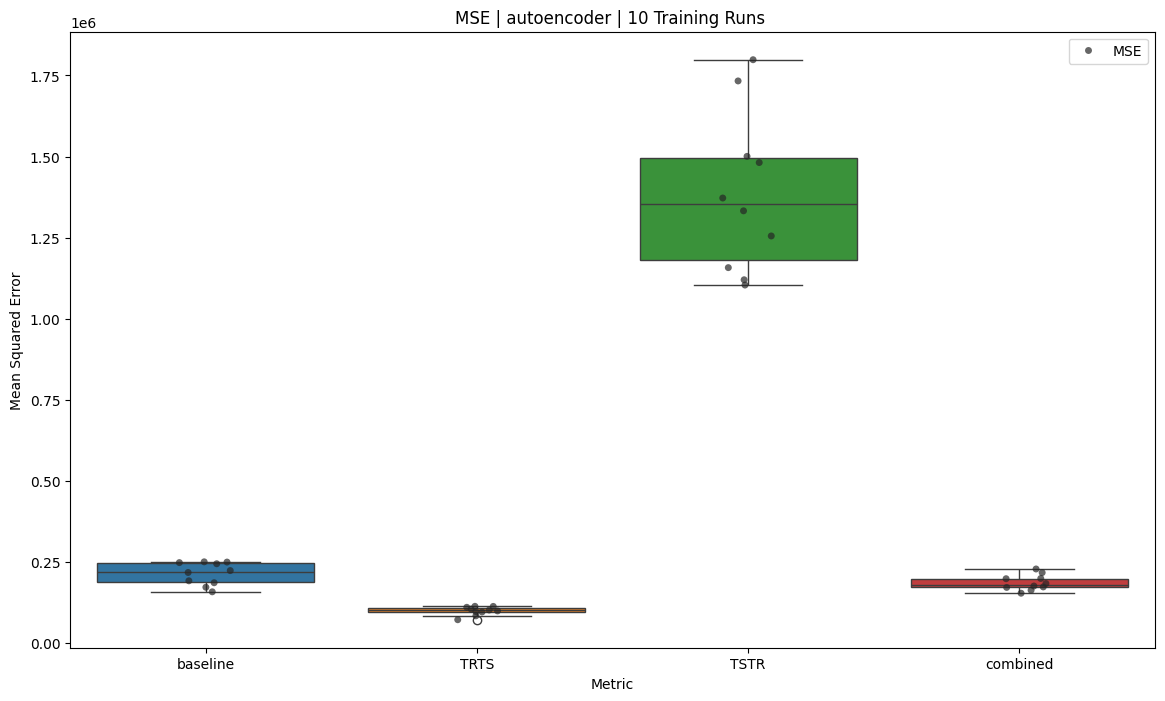

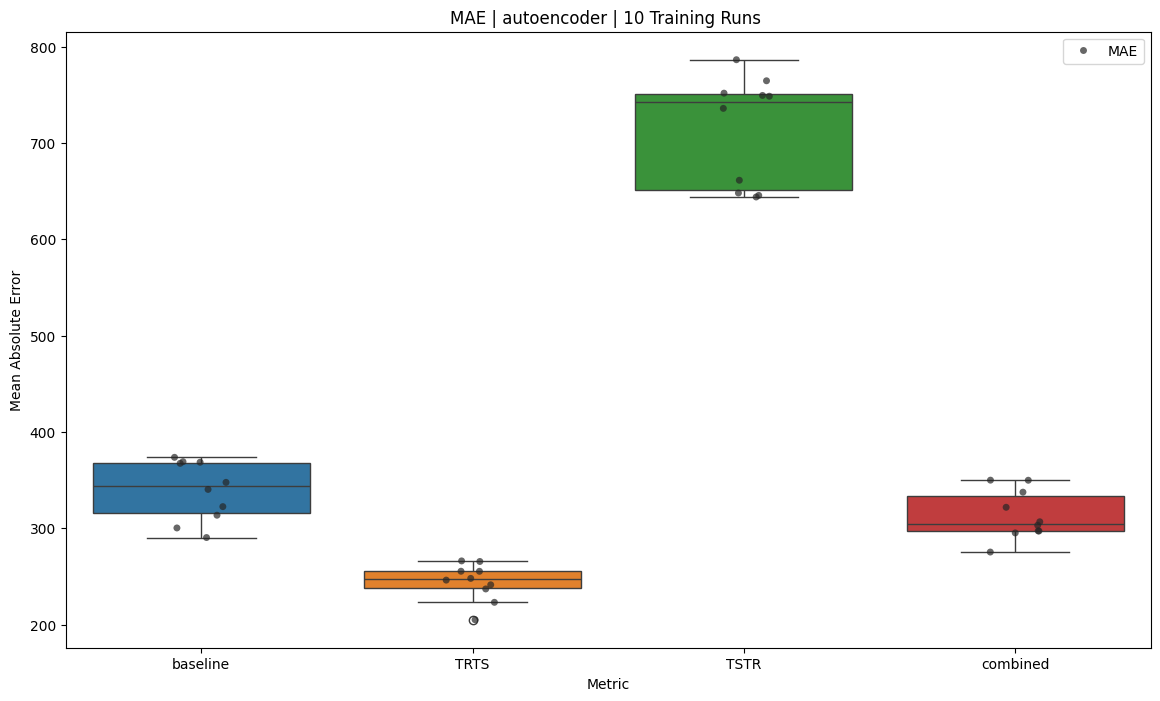

In [10]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [11]:
0.2*1e06

200000.0